In [338]:
import os
from typing import Tuple
from itertools import permutations

import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim, nn, utils, Tensor

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

In [386]:
DATASET_SIZE = 10_000
CIRCLES_COUNT_RANGE = (8, 20)  # min and max ount of circles in samples
PADDING_VALUE = 0

BATCH_SIZE = 128
EPOCHS = 20

NUM_WORKERS = 0

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

DATASET_PATH = './data_example/'  # must contain 'X.npy' and 'y.npy'

In [387]:
SEQUENCE_MAX_SIZE = CIRCLES_COUNT_RANGE[1]  # LSTM input requires sequences of equal lenth, so zero padding will be added to the end of each sample

## Generate data

### experiment

In [508]:
circles_count = 15

In [509]:
points = np.random.rand(circles_count, 2)

In [553]:
def euclidean(xy1: np.ndarray[2], xy2: np.ndarray[2]):
    manh_dist = xy2-xy1
    eucl_dist = np.sqrt(np.sum(np.square(manh_dist)))
    return eucl_dist

def generate_targets(points, radii):
    targets = []
    for point, rad in zip(points, radii):
        target = sum(point**2) * rad
        targets.append(-np.log(target))
    return targets

In [554]:
radii = []
targets = []
for point in points:
    distances = [euclidean(point, other_point) for other_point in points]
    distances = [distance for distance in distances if distance > 0]

    radius_relative_size = np.random.randint(30, 49)/100
    radius = np.min(distances) * radius_relative_size
    radii.append(radius)

    # target = np.square(np.sum(1-np.array(distances)))/len(distances)
    # target = target / radius / 100
    # targets.append(target)

targets = generate_targets(points, radii)

radii = np.array(radii)
targets = np.array(targets)

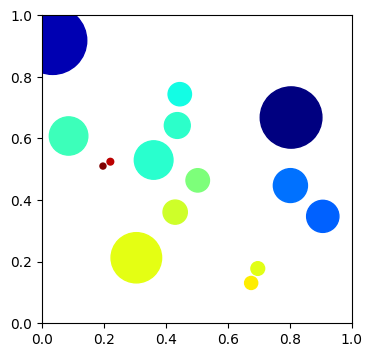

In [555]:
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.cm.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=np.min(targets), vmax=np.max(targets))
for point, radius, target in zip(points, radii, targets):
    circle = plt.Circle(point, radius, color=cmap(norm(target)))
    ax.add_patch(circle)


In [556]:
points.shape, radii.shape, targets.shape

((15, 2), (15,), (15,))

In [558]:
targets

array([2.37753712, 3.68019262, 4.48485197, 3.07191519, 5.65228462,
       4.60475465, 5.83974647, 2.21924083, 4.03171369, 3.66307644,
       4.39428626, 3.75414846, 3.56378113, 4.46861568, 3.01494213])

### create generator

In [529]:
def euclidean(xy1: np.ndarray[2], xy2: np.ndarray[2]):
    manh_dist = xy2-xy1
    eucl_dist = np.sqrt(np.sum(np.square(manh_dist)))
    return eucl_dist

def generate_targets(points, radii):
    targets = []
    for point, rad in zip(points, radii):
        target = sum(point**2) * rad
        targets.append(-np.log(target))
    return targets

In [530]:
def generate_example(
    circles_count: int, 
    seqnence_max_size: int = SEQUENCE_MAX_SIZE,
    padding_value: Tuple[float, int] = PADDING_VALUE) -> npt.NDArray:
    '''Generate example with specified number of circles'''
    points = np.random.rand(circles_count, 2)
    radii = []
    targets = []
    for point in points:
        distances = [euclidean(point, other_point) for other_point in points]
        distances = [distance for distance in distances if distance > 0]

        radius_relative_size = np.random.randint(30, 49)/100
        radius = np.min(distances) * radius_relative_size
        radii.append(radius)

        # target = np.square(np.sum(1-np.array(distances)))/len(distances)
        # targets.append(target)

    targets = generate_targets(points, radii)

    radii = np.array(radii).reshape((-1, 1))
    targets = np.array(targets).reshape((-1, 1))
    example = np.hstack((points, radii, targets))

    padding_size = seqnence_max_size - len(example)
    padding = np.zeros(shape=(padding_size, 4)) + padding_value
    example = np.vstack((example, padding))
    return example


In [531]:
def plot_example(example: np.ndarray, ax: plt.Axes):
    points = example[:, :2]
    radii = example[:, 2]
    targets = example[:, 3]
    cmap = plt.cm.get_cmap('jet')
    norm = mpl.colors.Normalize(vmin=np.min(targets), vmax=np.max(targets))
    for point, radius, target in zip(points, radii, targets):
        circle = plt.Circle(point, radius, color=cmap(norm(target)))
        ax.add_patch(circle)

    ax.set_xticks([])
    ax.set_yticks([])

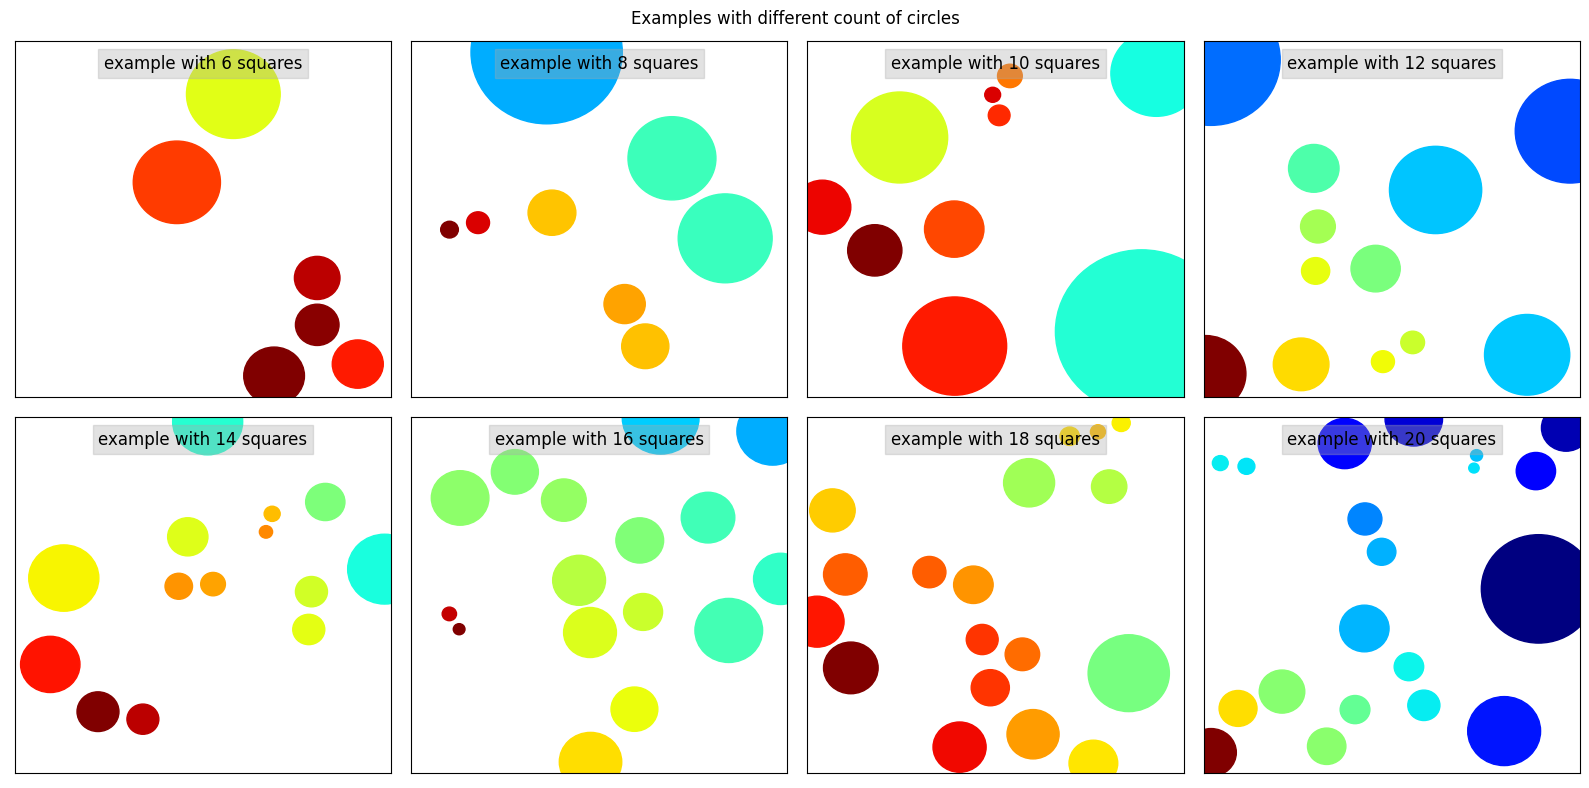

In [532]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axs = axs.ravel()
counts = np.arange(6, 22, 2)
for circles_count, ax in zip(counts, axs):
    example = generate_example(circles_count)
    plot_example(example, ax)
    ax.set_title(f'example with {circles_count} squares', y=0.9, backgroundcolor='#AAAAAA55')

fig.suptitle('Examples with different count of circles')
fig.tight_layout()

In [533]:
examples = []
circles_counts = np.random.randint(*CIRCLES_COUNT_RANGE, size=(DATASET_SIZE, ))

for circles_count in tqdm(circles_counts):
    example = generate_example(circles_count)
    examples.append(example)


100%|██████████| 10000/10000 [00:13<00:00, 750.95it/s]


In [534]:
examples = np.stack(examples, axis=0)

In [535]:
examples.shape

(10000, 20, 4)

Text(0.5, 0.98, 'Distributions of features and target')

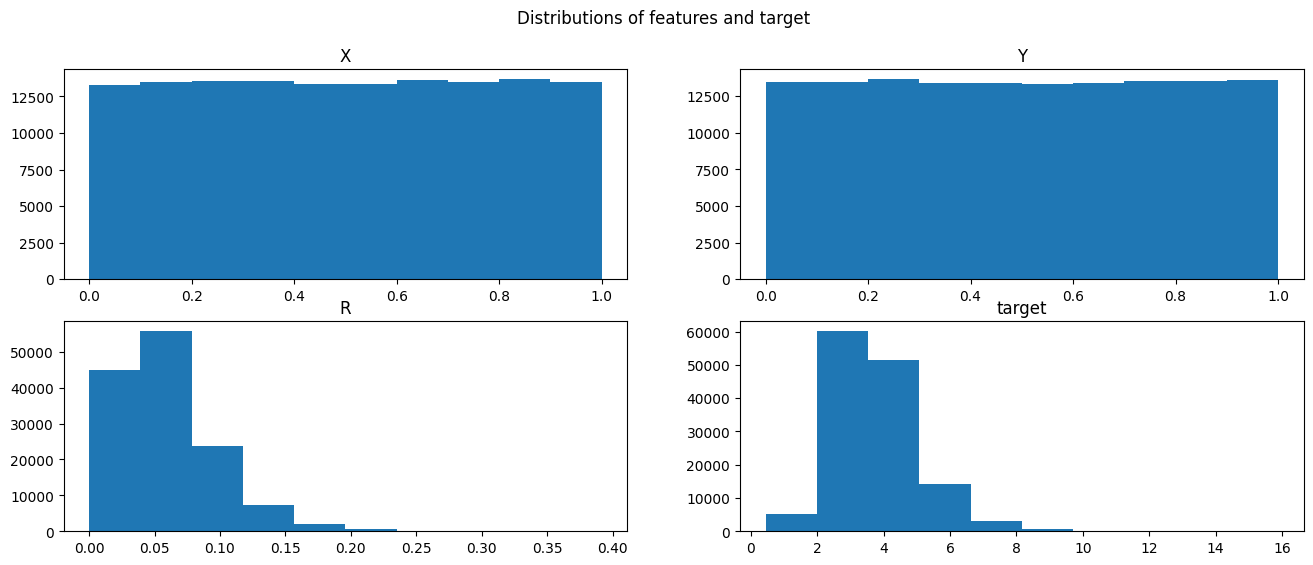

In [536]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))
axs = axs.ravel()

def truncate_padding(arr):
    return [el for el in arr.ravel() if el != PADDING_VALUE]

pos_x = truncate_padding(examples[:, :, 0])
pos_y = truncate_padding(examples[:, :, 1])
radii = truncate_padding(examples[:, :, 2])
targs = truncate_padding(examples[:, :, 3])

axs[0].hist(pos_x);
axs[0].set_title('X')
axs[1].hist(pos_y);
axs[1].set_title('Y')
axs[2].hist(radii);
axs[2].set_title('R')
axs[3].hist(targs);
axs[3].set_title('target')
fig.suptitle('Distributions of features and target')


In [537]:
y = np.max(examples[:, :, 3], axis=1)  # target is the max stress in a whole example
X = examples[:, :, :3]

In [538]:
y.shape

(10000,)

In [539]:
y_random_predicts = np.random.choice(y, size=len(y))

In [540]:
f"error of random model: {mean_squared_error(y_random_predicts, y)}"

'error of random model: 3.443422618517781'

In [541]:
np.save(os.path.join(DATASET_PATH, 'X.npy'), X)
np.save(os.path.join(DATASET_PATH, 'y.npy'), y)

## Model

#### data part

In [542]:
class CompositesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return self.X.__len__()

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [571]:
class CompisitesDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        batch_size: int = BATCH_SIZE, 
        train_ratio: float = TRAIN_RATIO,
        val_ratio: float = VAL_RATIO,
        dataset_path: str = DATASET_PATH,
        ):
        assert (train_ratio + val_ratio) < 1
        super().__init__()
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

    def setup(self, stage: str):
        X = np.load(os.path.join(self.dataset_path, 'X.npy'))
        y = np.load(os.path.join(self.dataset_path, 'y.npy'))
        dataset_size = X.shape[0]

        train_size = int(dataset_size * self.train_ratio)
        val_size = int(dataset_size * self.val_ratio)
        self.X_train, self.y_train = X[:train_size], y[:train_size]
        self.X_val, self.y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        self.X_test, self.y_test = X[train_size+val_size:], y[train_size+val_size:]

    def train_dataloader(self):
        dataset = CompositesDataset(self.X_train, self.y_train)
        return DataLoader(dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        dataset = CompositesDataset(self.X_val, self.y_val)
        return DataLoader(dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        dataset = CompositesDataset(self.X_test, self.y_test)
        return DataLoader(dataset, batch_size=self.batch_size)

    def predict_dataloader(self):
        dataset = CompositesDataset(self.X_test, self.y_test)
        return DataLoader(dataset, batch_size=self.batch_size)


#### lstm part

In [572]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion,
                 use_sample_permutation):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.use_sample_permutation = use_sample_permutation  # permute circles in sequence, as it is crucial in lstm

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        # self.linear = nn.Linear(hidden_size, 1)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.ELU(),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.ELU(),
            nn.Linear(hidden_size*4, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ELU(),
            nn.Linear(int(hidden_size/2), int(hidden_size/2)),
            nn.ELU(),
            nn.Linear(int(hidden_size/2), 1)
        )
    
    def get_target(self, x):
        y = []
        for x_i in x.cpu():
            points = x_i[:, :2]
            radii = x_i[:, 2]
            targets = []
            for point, radius in zip(points, radii):
                distances = [euclidean(point, other_point) for other_point in points]
                distances = [distance for distance in distances if distance > 0]

                target = np.square(np.sum(1-np.array(distances)))/len(distances)
                target = target / radius / 100
                targets.append(target)
            
            y_i = np.max(targets)
            y.append(y_i)
        y = torch.Tensor(y)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        y_pred = self.regressor(lstm_out[:,-1])
        # y_pred = self.get_target(x)
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.use_sample_permutation:
            x = x[torch.randperm(x.shape[0])]
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

In [573]:
model_settings = dict(
    seq_len = SEQUENCE_MAX_SIZE,
    batch_size = BATCH_SIZE, 
    criterion = nn.MSELoss(),
    max_epochs = EPOCHS,
    n_features = 3,  # x, y and radius
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.00003,
    use_sample_permutation=True
)

In [574]:
model_settings = dict(
    seq_len = SEQUENCE_MAX_SIZE,
    batch_size = BATCH_SIZE, 
    criterion = nn.MSELoss(),
    max_epochs = EPOCHS,
    n_features = 3,  # x, y and radius
    hidden_size = 256,
    num_layers = 3,
    dropout = 0.3,
    learning_rate = 0.00008,
    use_sample_permutation=True
)

In [575]:
seed_everything(1)

csv_logger = CSVLogger('./', name='lstm_logs', version='0'),

trainer = Trainer(
    max_epochs=model_settings['max_epochs'],
    logger=csv_logger,
    accelerator='gpu',  # use 'cpu' if you haven't GPU
    devices=1,
    log_every_n_steps=1
)


Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [576]:
model = LSTMRegressor(
    n_features = model_settings['n_features'],
    hidden_size = model_settings['hidden_size'],
    seq_len = model_settings['seq_len'],
    batch_size = model_settings['batch_size'],
    criterion = model_settings['criterion'],
    num_layers = model_settings['num_layers'],
    dropout = model_settings['dropout'],
    learning_rate = model_settings['learning_rate'],
    use_sample_permutation=model_settings['use_sample_permutation']
)

datamodule = CompisitesDataModule()

In [577]:
trainer.fit(model, datamodule)

d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory ./lstm_logs\0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | lstm      | LSTM       | 1.3 M 
2 | regressor | Sequential | 968 K 
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.155     Total estimated model params size (MB)
d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\lightning_fabric\loggers\csv_logs.py:183: UserWarning: Experiment logs directory ./lstm_logs\0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have m

Epoch 0:  82%|████████▏ | 55/67 [00:01<00:00, 29.29it/s, loss=4.3, v_num=0] 

d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 67/67 [00:02<00:00, 33.11it/s, loss=4.3, v_num=0]

d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19: 100%|██████████| 67/67 [00:02<00:00, 30.34it/s, loss=1.68, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 67/67 [00:02<00:00, 28.86it/s, loss=1.68, v_num=0]


torch.Size([128, 20, 256])

In [578]:
trainer.test(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Pythonprojects\university\MMIComposites\.mmic_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 42.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6849106550216675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6849106550216675}]

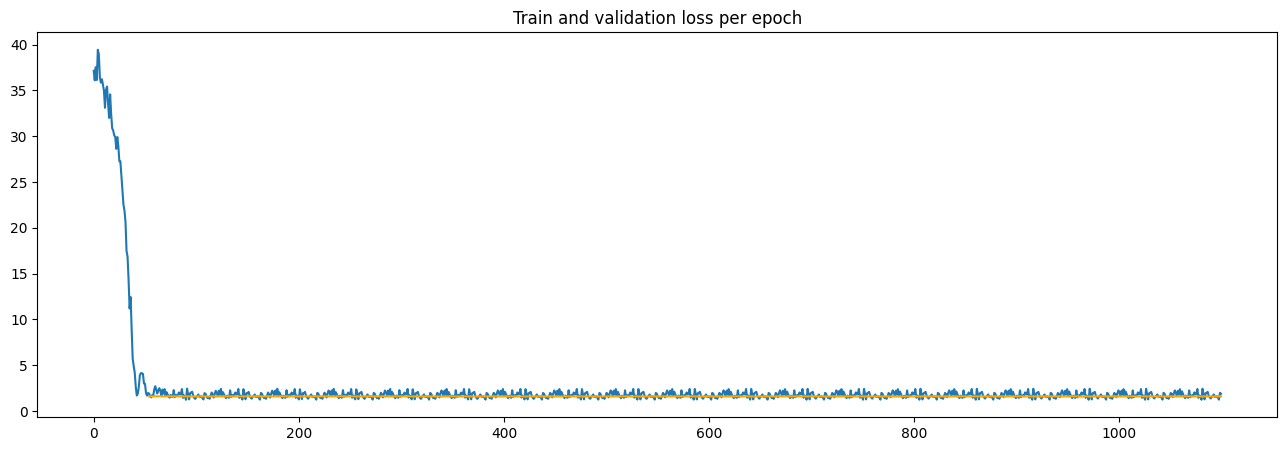

MSE:
Train loss: 1.885
Val loss:   1.592
Test loss:  1.685


In [579]:
metrics = pd.read_csv('./lstm_logs/0/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'step', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, ax = plt.subplots(figsize=(16, 5))
# axes[0].set_title('Train loss per batch')
ax.plot(train_loss['step'], train_loss['train_loss'], label='train')
# axes[1].set_title('Validation loss per epoch')
ax.plot(val_loss['step'], val_loss['val_loss'], color='orange', label='validation')
ax.set_title('Train and validation loss per epoch')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')